# 1. Загрузка данных

In [1]:
#!pip install kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, 
                            average_precision_score, 
                            balanced_accuracy_score,
                            confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

from kaggle.api.kaggle_api_extended import KaggleApi


In [3]:
# Инициализация API
api = KaggleApi()
api.authenticate()  # Проверяет ~/.kaggle/kaggle.json

# Скачивание данных соревнования
api.competition_download_files(
    "playground-series-s4e7",  # Название соревнования
    path="./data",             # Папка для сохранения
    quiet=False               # Показывать прогресс
)

# Распаковка архива (если нужно)
import zipfile
with zipfile.ZipFile("./data/playground-series-s4e7.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

In [20]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


Дальше будем работать только с датафреймом df_train, так как df_test не содержат целевую переменную и для обучения не годится

In [21]:
df = df_train

# 2. Обработка данных

### 2.1 Анализ пропущенных значений и дупликатов

In [8]:
missing_analysis = pd.DataFrame({
    'Количество пропусков': df.isnull().sum(),
    'Доля пропусков': df.isnull().mean().round(4)
})
print(missing_analysis[missing_analysis['Количество пропусков'] > 0])

print(f"Полных дубликатов строк: {df.duplicated().sum()}")
print(f"Частичных дубликатов по ID: {df['id'].duplicated().sum()}")


Empty DataFrame
Columns: [Количество пропусков, Доля пропусков]
Index: []
Полных дубликатов строк: 0
Частичных дубликатов по ID: 0


id в обучении не пригодится

In [22]:
df.drop('id', axis=1, inplace=True)

### 2.2 Сбалансированность классов

Посмотрим на соотношение классов Response. Это поможет нам потом выбрать правильные метрики

In [10]:
class_dist = df['Response'].value_counts(normalize=True)

print(f"Распределение классов:\n{class_dist}\n")
print(f"Соотношение классов: {class_dist[0]/class_dist[1]:.1f}:1")

Распределение классов:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

Соотношение классов: 7.1:1


Видно, что классы несбалансированы. Поэтому нельзя использовать в качестве метрики качества accuracy, например. Также, для обучения моделей нужно компенсировать малый класс через больший вес ошибки на этапе обучение. Для этого используем compute_class_weight

In [6]:
# Разделение с сохранением распределения
X = df.drop('Response', axis=1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Вычисление весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nВеса классов для компенсации дисбаланса: {class_weight_dict}")


Веса классов для компенсации дисбаланса: {0: 0.570123648963296, 1: 4.065131074836882}


Категориальные и числовые переменные

In [23]:
num_cols = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
            'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
cat_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
all_cols = num_cols + cat_cols

Сохраним датасет с числовыми признаками для бэйзлайн модели

In [8]:
X_train_base = X_train[num_cols]
X_test_base = X_test[num_cols]

### 2.3 Обработка категориальных признаков и нормализация

Сохраним датасет для последующей обработки категориальных признаков и нормализации

In [14]:
X_train_proc = X_train.copy()
X_test_proc = X_test.copy()

In [15]:
le = LabelEncoder()
for col in cat_cols:
    X_train_proc[col] = le.fit_transform(X_train_proc[col])
    X_test_proc[col] = le.transform(X_test_proc[col])

In [16]:
X_train_proc.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
4759874,0,25,1,50.0,1,1,0,35283.0,152.0,65
11227509,0,52,1,28.0,0,0,1,47269.0,26.0,114
700827,1,44,1,36.0,1,0,0,31854.0,124.0,34
10859621,0,49,1,50.0,0,0,1,23086.0,160.0,297
11120384,0,22,1,37.0,1,1,0,25416.0,152.0,193


Нормализация

In [17]:
scaler = MinMaxScaler()
X_train_proc[all_cols] = scaler.fit_transform(X_train_proc[all_cols])
X_test_proc[all_cols] = scaler.transform(X_test_proc[all_cols])


# 3. Генерация признаков и отбор

Признаки на основе полиномиальных комбинаций числовых признаков

In [18]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_proc[all_cols])
X_test_poly = poly.transform(X_test_proc[all_cols])

Применяем SelectKBest для отбора 10 лучших признаков

In [19]:
selector = SelectKBest(f_classif, k=10)
X_train_sel = selector.fit_transform(X_train_poly, y_train)
X_test_sel = selector.transform(X_test_poly)

# 4. Обучение моделей на сырых и разной степени обработки данных. Сравнение результатов

Создадим функцию для оценки модели по заданным метрикам

In [9]:
def evaluate_imbalanced(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return {
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp),
        'G-Mean': np.sqrt((tp/(tp+fn)) * (tn/(tn+fp)))
    }

Краткое описание выбранных метрик и причин их использования для задачи бинарной классификации с дисбалансом классов:

1. **F1-score** (Гармоническое среднее precision и recall)  
   - Почему: Балансирует между точностью и полнотой, что критично при дисбалансе классов  
   - Формула: `F1 = 2*(Precision*Recall)/(Precision+Recall)`

2. **PR-AUC** (Precision-Recall AUC)  
   - Почему: Лучше ROC-AUC для сильно дисбалансированных данных, фокусируется на качестве предсказаний positive-класса  
   - Особенность: Оценивает кривую precision-recall вместо ROC-кривой

3. **Balanced Accuracy**  
   - Почему: Учитывает accuracy для каждого класса отдельно, затем усредняет  
   - Формула: `(Sensitivity + Specificity)/2`

4. **G-Mean** (Геометрическое среднее sensitivity и specificity)  
   - Почему: Наказывает за большие различия в ошибках между классами  
   - Формула: `√(Sensitivity * Specificity)`

**Дополнительно в коде используются:**
- **Sensitivity (Recall)** - способность находить все positive-случаи  
- **Specificity** - способность правильно идентифицировать negative-случаи

**Почему не accuracy?**  
При дисбалансе 80:20 модель может получить accuracy=0.8, просто всегда предсказывая majority-класс, что бесполезно на практике. Выбранные метрики устойчивы к дисбалансу.

In [21]:
results = {}

### 4.1 Бейзлайн модель

In [22]:
lr_base = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
results['Baseline'] = evaluate_imbalanced(lr_base, X_train_base, X_test_base, y_train, y_test)

### 4.2 С обработкой категориальных и нормализацией

In [23]:
lr_proc = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
results['Processed'] = evaluate_imbalanced(lr_proc, X_train_proc[all_cols], X_test_proc[all_cols], y_train, y_test)

### 4.3 С полиномиальными признаками

In [24]:
lr_poly = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
results['Polynomial'] = evaluate_imbalanced(lr_poly, X_train_poly, X_test_poly, y_train, y_test)

Обучение занимает много времени. Можно будет попробовать снизить размерность через PCA

### 4.4 С отбором признаков

In [25]:
lr_sel = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
results['Selected Features'] = evaluate_imbalanced(lr_sel, X_train_sel, X_test_sel, y_train, y_test)


### 4.5 Табличка метриками разных мелей

Сравнение моделей по ключевым метрикам

In [26]:
results_df = pd.DataFrame(results).T.round(3)

key_metrics = ['F1-score', 'PR-AUC', 'Balanced Accuracy', 'G-Mean']
results_df[key_metrics]


,F1-score,PR-AUC,Balanced Accuracy,G-Mean
Baseline,0.263,0.165,0.590,0.588
Processed,0.402,0.299,0.787,0.763
Polynomial,0.432,0.346,0.800,0.788
Selected Features,0.402,0.257,0.787,0.763


Лучшие метрики у модели со сгенерированными полиномиальными признаками. Модель с обработкой категориальных признаков и нормализацией тоже показывает хорошие результаты, но она существенно быстрее

Все посчитанные метрики

In [27]:
results_df

,F1-score,ROC-AUC,PR-AUC,Balanced Accuracy,Sensitivity,Specificity,G-Mean
Baseline,0.263,0.660,0.165,0.590,0.540,0.640,0.588
Processed,0.402,0.824,0.299,0.787,0.981,0.593,0.763
Polynomial,0.432,0.849,0.346,0.800,0.934,0.665,0.788
Selected Features,0.402,0.804,0.257,0.787,0.981,0.593,0.763


Если будет время можно будет добавить метрику скорости работы модели, а также понизить размерность модели с полиномиальными признаками через метод главных компонент

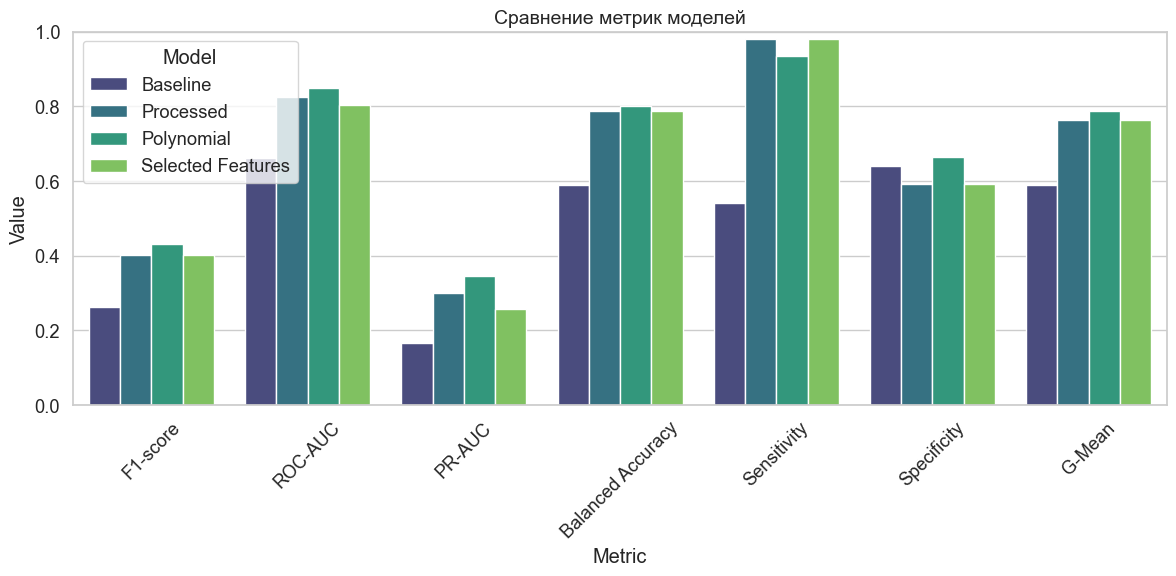

In [51]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Переворачиваем для удобного отображения
df_plot = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')

ax = sns.barplot(data=df_plot, x='Metric', y='Value', hue='index', palette='viridis')
plt.title('Сравнение метрик моделей', fontsize=14)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Примените основные методы по определению выбросов в данных

### 5.1 Cтатистический подход по поиску выбросов

In [30]:
# Для числовых признаков - не совпадает с num_cols, так как ['Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel'] - это хоть и числа, но по суть оцифрованные категориальные признаки
numeric_cols = ['Age', 'Annual_Premium', 'Vintage']

# Метод IQR
def iqr_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))]

# Метод Z-score
def zscore_outliers(df, col, threshold=3):
    z = np.abs((df[col] - df[col].mean()) / df[col].std())
    return df[z > threshold]

# Поиск выбросов
iqr_outliers_list = [iqr_outliers(df, col) for col in numeric_cols]
z_outliers_list = [zscore_outliers(df, col) for col in numeric_cols]

print(f"Найдено выбросов по IQR: {sum(len(x) for x in iqr_outliers_list)}")
print(f"Найдено выбросов по Z-score: {sum(len(x) for x in z_outliers_list)}")

Найдено выбросов по IQR: 2377273
Найдено выбросов по Z-score: 16911


### 5.2 Настройка и применение DBSCAN

In [29]:
df.shape

(11504798, 11)

Более 11 млн строк. DBSCAN не справится на обычном компьютере. Будем использовать HDBSCAN и обрабатывать данные частями. Результат с помеченными как выбросы (кластер -1) данными запишем в отдельный табличный файл. Следующий код мне помог написать LLM.
Как работает код ниде:
1. Понижается разрядность числовых данных - данные занимают меньше места в памяти
2. Используется HDBSCAN - усовершенствованный DBSCAN
3. Данные разбиваются на повыборки и кластеры ищутся в подвыборках - так мы не перегружаем память
4. Промежуточные и окончательный результаты сохраняются в отдельный файл - чтобы не держать все в памяти

In [30]:
#!pip install hdbscan

In [31]:
import hdbscan
from tqdm import tqdm
import time
import os
from sklearn.ensemble import IsolationForest

# Уменьшаем использование памяти
def reduce_mem_usage(df, numeric_cols):
    """Оптимизация памяти для числовых колонок DataFrame"""
    for col in numeric_cols:
        col_type = df[col].dtype
        if str(col_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        else:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    return df

# Безопасное предсказание HDBSCAN
def safe_hdbscan_predict(clusterer, X, chunk_size=500000):
    """Предсказание по частям для больших данных"""
    labels = np.full(len(X), -1, dtype=np.int8)
    for i in tqdm(range(0, len(X), chunk_size), desc="Предсказание"):
        chunk = X[i:i+chunk_size]
        try:
            chunk_labels, _ = hdbscan.approximate_predict(clusterer, chunk)
            labels[i:i+chunk_size] = chunk_labels
        except Exception:
            chunk_labels = clusterer.predict(chunk)
            labels[i:i+chunk_size] = chunk_labels
    return labels

# Основной код
def detect_outliers(df, numeric_cols):
    # 1. Подготовка данных
    print("Подготовка данных...")
    df = reduce_mem_usage(df.copy(), numeric_cols)
    
    # 2. Масштабирование
    print("Масштабирование признаков...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[numeric_cols])
    
    # 3. Создаем папку для кеша
    os.makedirs('./hdbscan_cache', exist_ok=True)
    
    # 4. Настройка HDBSCAN
    print("Поиск выбросов с HDBSCAN...")
    start_time = time.time()
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=50,
        min_samples=10,
        cluster_selection_epsilon=0.1,
        approx_min_span_tree=True,
        gen_min_span_tree=False,
        core_dist_n_jobs=2,
        memory='./hdbscan_cache',
        prediction_data=True
    )
    
    # 5. Обучение на подвыборке
    sample_size = min(200000, len(X_scaled))
    sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
    
    try:
        clusterer.fit(X_scaled[sample_idx])
        
        if not hasattr(clusterer, 'prediction_data_'):
            raise RuntimeError("HDBSCAN не сгенерировал данные для предсказания")
        
        # 6. Предсказание для всех данных
        all_labels = safe_hdbscan_predict(clusterer, X_scaled)
        df['hdbscan_outlier'] = all_labels == -1
        
    except Exception as e:
        print(f"[Ошибка] HDBSCAN: {str(e)}. Используем IsolationForest...")
        clf = IsolationForest(n_estimators=100, contamination='auto', n_jobs=2)
        clf.fit(X_scaled[sample_idx])
        df['hdbscan_outlier'] = clf.predict(X_scaled) == -1
    
    print(f"Найдено выбросов: {df['hdbscan_outlier'].sum()}")
    print(f"Время выполнения: {time.time()-start_time:.2f} сек")
    
    # 7. Сохранение результатов с корректными форматами данных
    print("Сохранение результатов...")
    for col in df.select_dtypes(include=['float16']).columns:
        df[col] = df[col].astype(np.float32)
    for col in df.select_dtypes(include=['int8', 'int16']).columns:
        df[col] = df[col].astype(np.int32)
    
    df.to_parquet('data_with_outliers.parquet', engine='pyarrow')
    print("Готово! Результаты сохранены в data_with_outliers.parquet")
    
    return df

  
numeric_cols = ['Age', 'Annual_Premium', 'Vintage']
df_with_outliers = detect_outliers(df, numeric_cols)

Подготовка данных...
Масштабирование признаков...
Поиск выбросов с HDBSCAN...


Предсказание: 100%|██████████| 24/24 [27:50<00:00, 69.59s/it]


Найдено выбросов: 5317
Время выполнения: 1724.86 сек
Сохранение результатов...
Готово! Результаты сохранены в data_with_outliers.parquet


30 минут! И это после оптимизации, которую я бы без DeepSeek не сделал. А выбросов меньше 1%. Выглядит неубедительно. Посмотрим, какие будут метрики качества

### 5.3 Обучение модели без выбросов

Теперь обучим 4 модели на данных без выбросов. У нас для каждой модели будет 3 варианта обучения: с выбросами, без выбросов через стат метод IQR и без выбросов IQR + HDBSCAN. Соберем все метрики в единую таблицу, визаулизируем и сравним

Загрузка данных с выбросами. Вспомним типы колонок

In [ ]:
df = pd.read_parquet('data_with_outliers.parquet')


In [24]:
numeric_cols = ['Age', 'Annual_Premium', 'Vintage']
cat_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
target_col = 'Response'

Подготовка трех типов данных: с выбросами, без выбросов IQR и без выбросов IQR+HDBSCAN

In [10]:
def prepare_data_types(df, numeric_cols):
    # 1. Данные с выбросами
    df_with_outliers = df.copy()
    
    # 2. Данные, очищенные только IQR
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    iqr_mask = ~((df[numeric_cols] < (Q1 - 1.5*IQR)) | 
                (df[numeric_cols] > (Q3 + 1.5*IQR))).any(axis=1)
    df_iqr_clean = df[iqr_mask].copy()
    
    # 3. Данные, очищенные HDBSCAN и IQR
    hdbscan_iqr_mask = iqr_mask & (~df['hdbscan_outlier'])
    df_hdbscan_iqr_clean = df[hdbscan_iqr_mask].copy()
    
    return {
        'with_outliers': df_with_outliers,
        'iqr_clean': df_iqr_clean,
        'hdbscan_iqr_clean': df_hdbscan_iqr_clean
    }


Подготовка данных для обучения: обучение/тест, баланс классов

In [16]:
def prepare_train_test(df, numeric_cols, cat_cols, target_col):
    X = df.drop([target_col, 'hdbscan_outlier'], axis=1, errors='ignore')
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    return X_train, X_test, y_train, y_test, class_weight_dict

Обучение и оценка разных типов моделей

In [12]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, class_weight, numeric_cols, cat_cols):
    results = {}
    lr = LogisticRegression(class_weight=class_weight, max_iter=1000)
    
    # 1. Базовые числовые признаки
    results['Baseline'] = evaluate_imbalanced(lr, X_train[numeric_cols], X_test[numeric_cols], y_train, y_test)
    
    # 2. С обработкой категориальных
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    
    le = LabelEncoder()
    for col in cat_cols:
        X_train_proc[col] = le.fit_transform(X_train_proc[col])
        X_test_proc[col] = le.transform(X_test_proc[col])
    
    scaler = StandardScaler()
    all_cols = numeric_cols + cat_cols
    X_train_proc[all_cols] = scaler.fit_transform(X_train_proc[all_cols])
    X_test_proc[all_cols] = scaler.transform(X_test_proc[all_cols])
    
    results['Processed'] = evaluate_imbalanced(lr, X_train_proc[all_cols], X_test_proc[all_cols], y_train, y_test)
    
    # 3. С полиномиальными признаками
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_proc[all_cols])
    X_test_poly = poly.transform(X_test_proc[all_cols])
    
    results['Polynomial'] = evaluate_imbalanced(
        lr, X_train_poly, X_test_poly, y_train, y_test)
    
    # 4. С отбором признаков
    selector = SelectKBest(f_classif, k=15)
    X_train_sel = selector.fit_transform(X_train_poly, y_train)
    X_test_sel = selector.transform(X_test_poly)
    
    results['Selected'] = evaluate_imbalanced(lr, X_train_sel, X_test_sel, y_train, y_test)
    
    return results

Подготовка данных разных типов - с выбросами, без выбросов IQR и без выбросов IQR+DBSCAN

In [36]:
data_types = prepare_data_types(df, numeric_cols)

Обучение и оценка моделей для каждого типа данных

In [37]:
all_results = []

for data_name, data_df in data_types.items():
    print(f"\nОбработка данных: {data_name.replace('_', ' ').title()}")
    X_train, X_test, y_train, y_test, class_weight = prepare_train_test(data_df, numeric_cols, cat_cols, target_col)
    
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test, class_weight, numeric_cols, cat_cols)
    
    # Добавляем информацию о типе данных
    for model_name, metrics in results.items():
        metrics['Data Type'] = data_name.replace('_', ' ').title()
        metrics['Model Type'] = model_name
        all_results.append(metrics)


Обработка данных: With Outliers

Обработка данных: Iqr Clean

Обработка данных: Hdbscan Iqr Clean


Создание итоговой таблицы

In [38]:
final_results = pd.DataFrame(all_results)
final_results = final_results[['Data Type', 'Model Type', 'F1-score', 'ROC-AUC', 'PR-AUC','Balanced Accuracy', 'Sensitivity', 'Specificity', 'G-Mean']].round(3)

final_results


,Data Type,Model Type,F1-score,ROC-AUC,PR-AUC,Balanced Accuracy,Sensitivity,Specificity,G-Mean
0,With Outliers,Baseline,0.244,0.589,0.143,0.567,0.656,0.478,0.560
1,With Outliers,Processed,0.386,0.795,0.254,0.774,0.983,0.564,0.745
2,With Outliers,Polynomial,0.421,0.835,0.318,0.789,0.924,0.654,0.778
3,With Outliers,Selected,0.422,0.834,0.317,0.789,0.923,0.656,0.778
4,Iqr Clean,Baseline,0.266,0.621,0.150,0.603,0.658,0.549,0.601
5,Iqr Clean,Processed,0.396,0.805,0.253,0.788,0.987,0.588,0.762
6,Iqr Clean,Polynomial,0.432,0.845,0.324,0.802,0.932,0.672,0.791
7,Iqr Clean,Selected,0.432,0.844,0.322,0.802,0.931,0.672,0.791
8,Hdbscan Iqr Clean,Baseline,0.266,0.621,0.150,0.603,0.658,0.549,0.601
9,Hdbscan Iqr Clean,Processed,0.396,0.805,0.253,0.787,0.987,0.588,0.762


Надо в следующий раз попробовать pipeline. Также полезно выводить время обучения

### 5.4 Визуализация и выводы

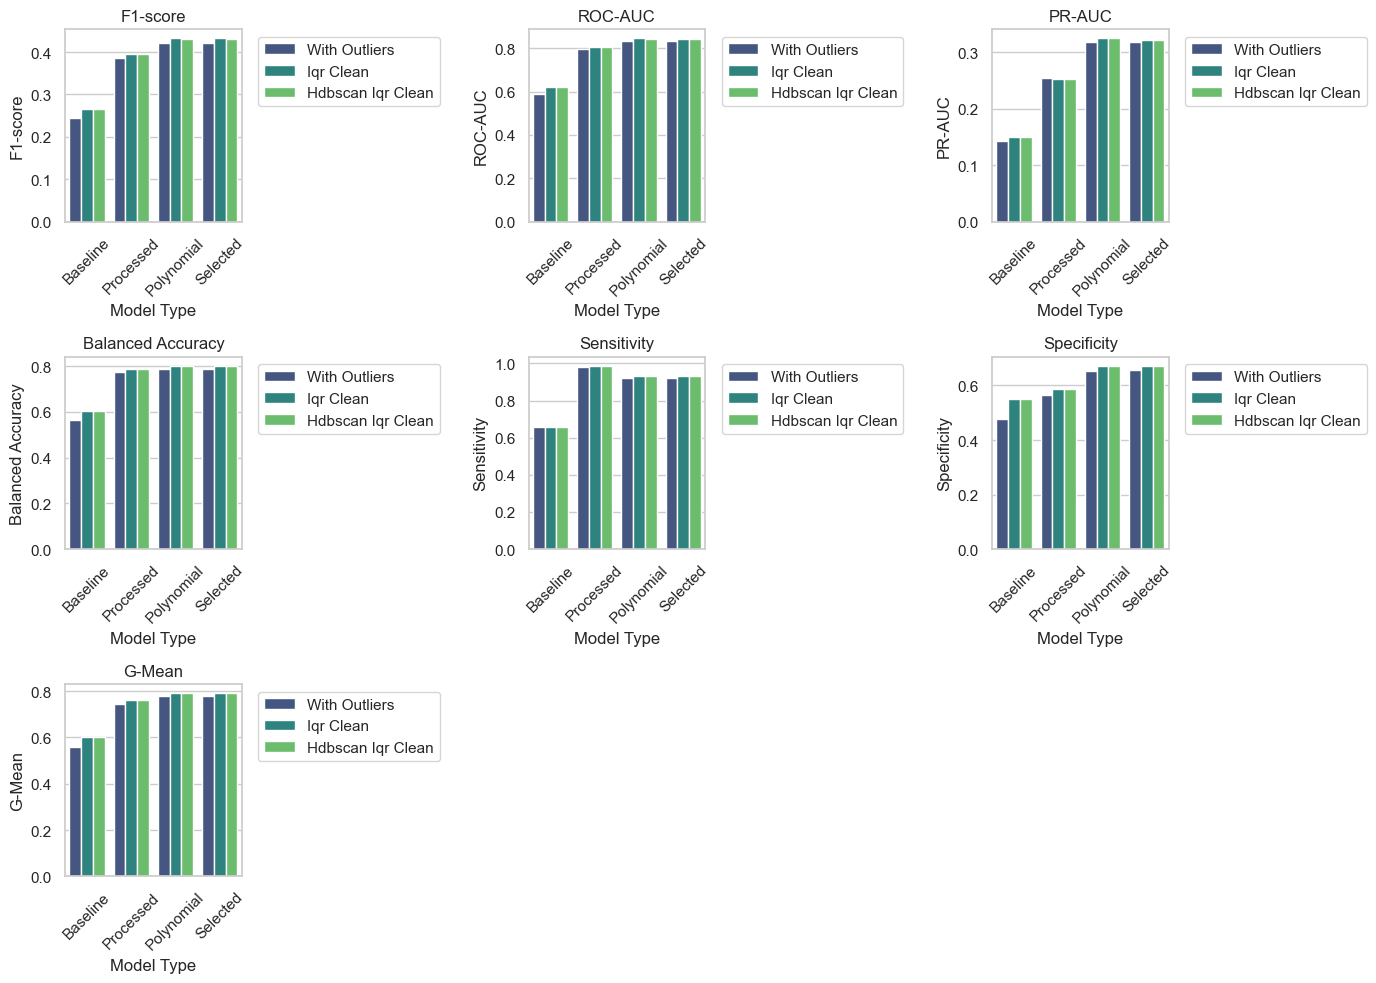

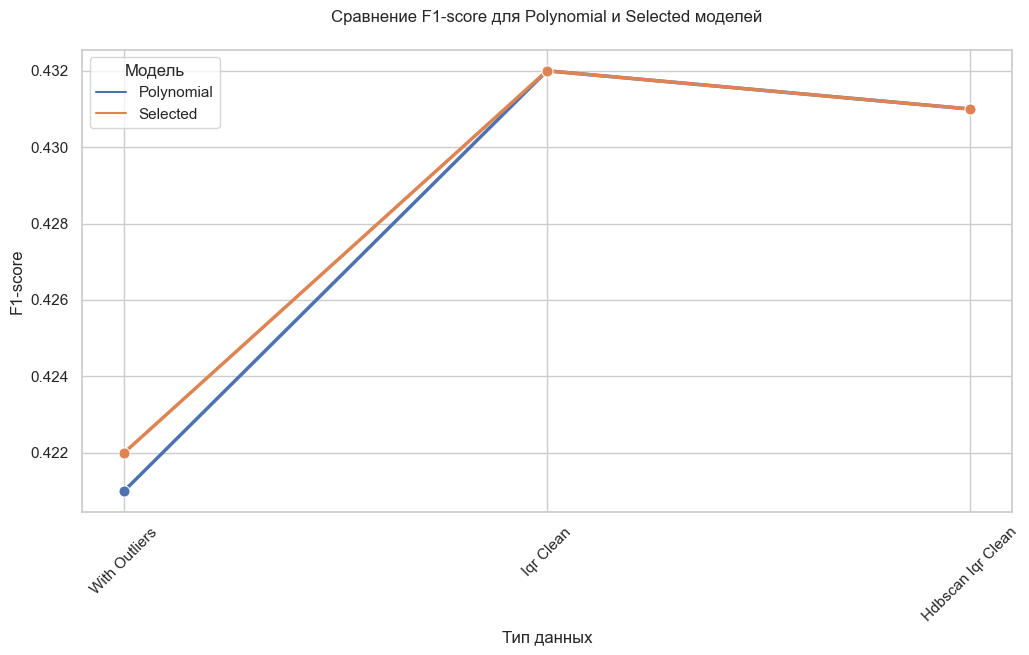

In [39]:
# Настройка стиля графиков
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

# Список метрик для визуализации
metrics = ['F1-score', 'ROC-AUC', 'PR-AUC', 'Balanced Accuracy', 'Sensitivity', 'Specificity', 'G-Mean']

# Построение графиков для каждой метрики
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.barplot(data=final_results, x='Model Type', y=metric, hue='Data Type', palette='viridis')
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Дополнительная визуализация: сравнение лучших моделей (Polynomial и Selected)
best_models = final_results[final_results['Model Type'].isin(['Polynomial', 'Selected'])]
plt.figure(figsize=(12, 6))
sns.lineplot(data=best_models, x='Data Type', y='F1-score', hue='Model Type', 
             marker='o', markersize=8, linewidth=2.5)
plt.title('Сравнение F1-score для Polynomial и Selected моделей', pad=20)
plt.xticks(rotation=45)
plt.ylabel('F1-score')
plt.xlabel('Тип данных')
plt.legend(title='Модель')
plt.show()



- HDBSCAN при всей затратности и сложности не повышает качество. В дальнейшим можно его исключить
- Лучшие модели: "Polynomial" и "Selected" после обработки выбросов демонстрируют практически идентичные и наивысшие результаты по всем метрикам, что делает их лучшими среди представленных
- Помним, что модель "Selected" (с отобранными признаками)  после IQR обработи выбросов работает быстрее. Поэтом лучше использовать ее 


# 6. Модель ансамбля

Теперь добавим модель случайного леса. Попробуем использовать pipeline для удобства. Для подбора опитмальных гиперпараметров для случайного леса будем использовать Hyperopt. 

В итоге будем сравнивать метрики трех моделей:
 - Baseline: логистическая регрессия на числовых признаках
 - Selected: логистическая регрессия на обработанных данных: категориальные признаки, отбор полиномиальных признаков и IQR обработка выбросов
 - Random Forest: случайный лес с подбором гиперпараметров через Hyperopt на обработанных данных

Сначала запустим случайны лес с какими-то гиперпапаметрами, а потом попробуем подобрать оптимальные через Hyperopt. 

### 6.1 Случайный лес

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import iqr
from sklearn.preprocessing import OrdinalEncoder


In [14]:
# Функция оценки
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp),
        'G-Mean': np.sqrt((tp/(tp+fn)) * (tn/(tn+fp)))
    }

Подготовим данные и посчитаем метрики базовой модели

In [25]:
X_train, X_test, y_train, y_test, class_weight_dict = prepare_train_test(df, numeric_cols, cat_cols, target_col)

In [26]:
baseline_model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
baseline_model.fit(X_train[numeric_cols], y_train)
metrics_base= evaluate_model(baseline_model, X_test[numeric_cols], y_test)

Пайплайн для препроцессинга: масштабирование числовых признаков и обработка категориальных

In [27]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

Удаление выбросов - только через IQR, без DBSCAN, так как он тяжелый и не сильно влияет на результат

In [28]:
def remove_outliers_iqr(df, columns):
    outlier_indices = set()
    for col in columns:
        outliers = iqr_outliers(df, col)
        outlier_indices.update(outliers.index)
    return df.drop(index=outlier_indices)

In [31]:
X_train_clean = remove_outliers_iqr(X_train, num_cols)
y_train_clean = y_train.loc[X_train_clean.index]

Метрики логистической регрессии после обработки. Посчитаем через пайпдайн

In [32]:
lr_processed = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', LogisticRegression(class_weight=class_weight_dict, random_state=42))
])


lr_processed.fit(X_train, y_train)
metrics_processed= evaluate_model(lr_processed, X_test, y_test)

Метрики случайного леса. Гиперпараметры взяты случайно

In [33]:
rf_some_params = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('feature_selector', SelectKBest(f_classif, k=15)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight=class_weight_dict,
        n_jobs=-1,
        random_state=42
    ))
])

rf_some_params.fit(X_train, y_train)
metrics_rf= evaluate_model(rf_some_params, X_test, y_test)

/Users/mikhail/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/mikhail/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [34]:
metrics_df = pd.DataFrame([metrics_base, metrics_processed, metrics_rf], index=['Baseline', 'LogReg_Processed', 'RandForest_Processed'])
metrics_df

,F1-score,ROC-AUC,PR-AUC,Balanced Accuracy,Sensitivity,Specificity,G-Mean
Baseline,0.243964,0.588705,0.143435,0.567011,0.655904,0.478119,0.560000
LogReg_Processed,0.401389,0.842528,0.321247,0.784877,0.972976,0.596778,0.762005
RandForest_Processed,0.435838,0.858840,0.369974,0.802117,0.934191,0.670042,0.791169


### 6.2 Визуализация - сравнение трех моделей

Визуализация в виде таблицы

In [49]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(10, 4))
sns.set(font_scale=1.2)

# Создаем кастомную цветовую карту
cmap = LinearSegmentedColormap.from_list('rg', ["red", "yellow", "green"], N=256)

# Стилизуем таблицу
styled_df = metrics_df.style\
    .background_gradient(cmap=cmap, vmin=0, vmax=1)\
    .set_properties(**{'font-size': '12pt', 'font-family': 'Arial'})\
    .format("{:.3f}")

display(styled_df.set_caption("Сравнение метрик моделей (чем зеленее - тем лучше)"))

,F1-score,ROC-AUC,PR-AUC,Balanced Accuracy,Sensitivity,Specificity,G-Mean
Baseline,0.244,0.589,0.143,0.567,0.656,0.478,0.560
LogReg_Processed,0.401,0.842,0.321,0.785,0.972,0.597,0.762
RandForest_Processed,0.434,0.858,0.367,0.802,0.939,0.665,0.790


<Figure size 1000x400 with 0 Axes>

Визуализация в виде графиков

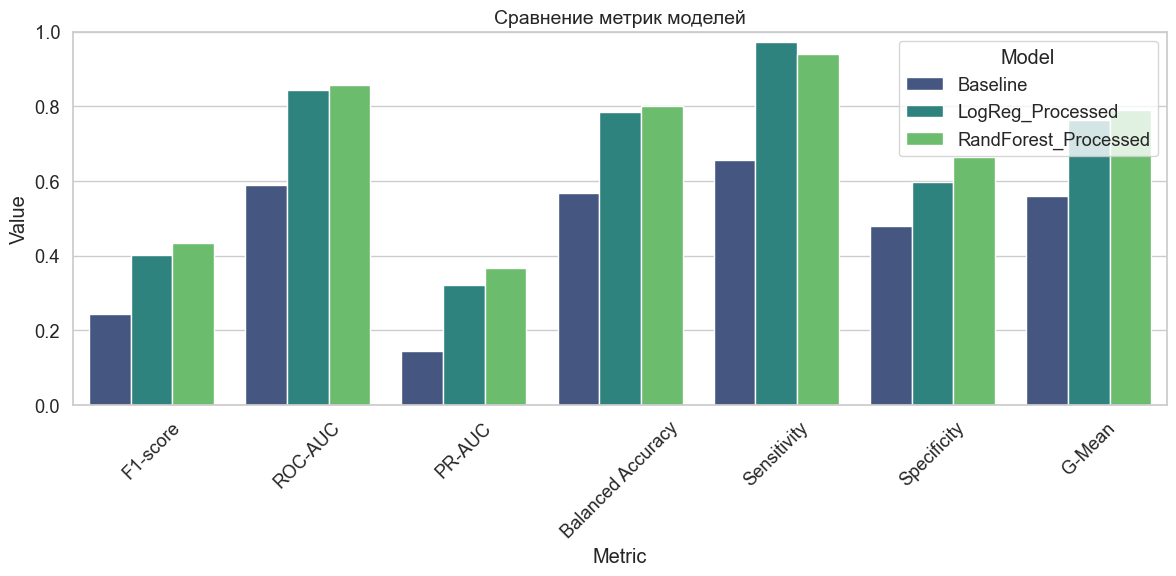

In [50]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Переворачиваем для удобного отображения
df_plot = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')

ax = sns.barplot(data=df_plot, x='Metric', y='Value', hue='index', palette='viridis')
plt.title('Сравнение метрик моделей', fontsize=14)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Вывод: случайный лес даже без подбора гиперпараметров оказался немного лучше логистической регрессии на обработанных данных и сильно лучше базовой модели

### 6.2 Подбор оптимальных гиперпараметров

# 7. Сохранение модели для использования

Сохраним лучшую модель 

In [38]:
import joblib

joblib.dump(rf_some_params, 'model.pkl')


['model.pkl']

In [39]:
rf_some_params = joblib.load('model.pkl')
rf_some_params

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('poly', PolynomialFeatures(interaction_only=True)),
                ('feature_selector', SelectKBest(k=15)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 0.570123648963296,
                                                      1: 4.065131074836882},
                                        max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5, n_jobs=-1,
                                        random_state=42))])